In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.formula.api import glm
from statsmodels.genmod.bayes_mixed_glm import BinomialBayesMixedGLM
import statsmodels.formula.api as smf
from statsmodels.genmod.generalized_estimating_equations import GEE
from statsmodels.genmod.families import Binomial
from statsmodels.genmod.cov_struct import Exchangeable
import seaborn as sns
from pandas.api.types import CategoricalDtype

In [2]:
all_evaluated_df = pd.read_csv("all_evaluated_responses.csv")

order = ["paper","no_instruction", "with_description"]


all_evaluated_df["instruction_type"] = pd.Categorical(
    all_evaluated_df["instruction_type"],
    categories=order,
    ordered=False
)

binary_datasets = ["ggr", "vlat", "calvi"]
# continuous_datasets = ["holf", "holf2"]

df_binary = all_evaluated_df[all_evaluated_df["test_type"].isin(binary_datasets)].copy()
# df_continuous = all_evaluated_df[all_evaluated_df["test_type"].isin(continuous_datasets)].copy()

In [3]:
model_bin = GEE.from_formula(
    "is_correct ~ agent_type * instruction_type",
    groups="item_id",
    cov_struct=Exchangeable(),
    data=df_binary,
    family=Binomial()
)
result_bin = model_bin.fit()
print(result_bin.summary())

                               GEE Regression Results                              
Dep. Variable:                  is_correct   No. Observations:                 1410
Model:                                 GEE   No. clusters:                       47
Method:                        Generalized   Min. cluster size:                  30
                      Estimating Equations   Max. cluster size:                  30
Family:                           Binomial   Mean cluster size:                30.0
Dependence structure:         Exchangeable   Num. iterations:                     2
Date:                     Sat, 30 Aug 2025   Scale:                           1.000
Covariance type:                    robust   Time:                         07:40:48
                                                               coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------------------------

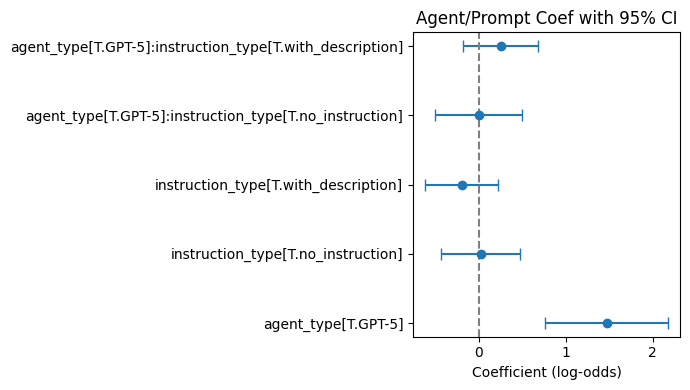

In [4]:
params = result_bin.params
conf = result_bin.conf_int()
conf["coef"] = params
conf.columns = ["2.5%", "97.5%", "coef"]

conf_plot = conf.drop("Intercept")

fig, ax = plt.subplots(figsize=(7,4))
ax.errorbar(conf_plot["coef"], conf_plot.index,
            xerr=[conf_plot["coef"]-conf_plot["2.5%"], conf_plot["97.5%"]-conf_plot["coef"]],
            fmt="o", capsize=4)
ax.axvline(0, color="grey", linestyle="--")
ax.set_xlabel("Coefficient (log-odds)")
ax.set_title("Agent/Prompt Coef with 95% CI")
plt.tight_layout()
plt.show()

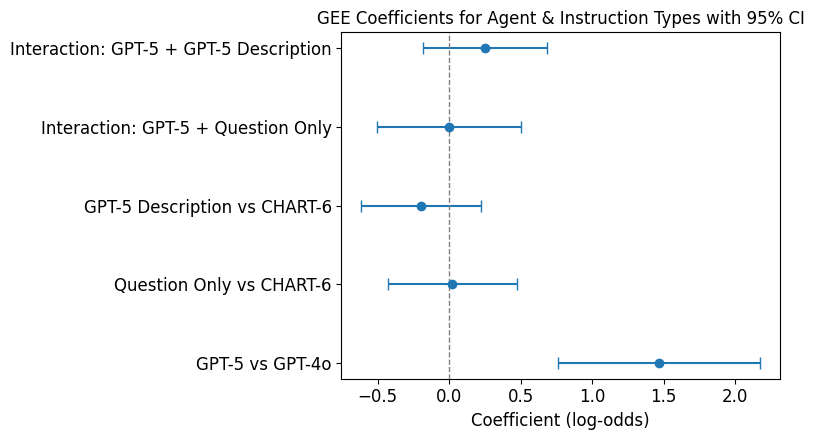

In [ ]:
params = result_bin.params
conf = result_bin.conf_int()
conf["coef"] = params
conf.columns = ["2.5%", "97.5%", "coef"]

# Drop intercept
conf_plot = conf.drop("Intercept")

# Map technical names to nicer labels
label_map = {
    "agent_type[T.GPT-5]": "GPT-5 vs GPT-4o",
    "instruction_type[T.no_instruction]": "Question Only vs CHART-6",
    "instruction_type[T.with_description]": "GPT-5 Description vs CHART-6",
    "agent_type[T.GPT-5]:instruction_type[T.no_instruction]": "Interaction: GPT-5 + Question Only",
    "agent_type[T.GPT-5]:instruction_type[T.with_description]": "Interaction: GPT-5 + GPT-5 Description"
}

conf_plot = conf_plot.rename(index=label_map)

# Explicit ordering (main effects first, then interactions)
order = [
    "GPT-5 vs GPT-4o",
    "Question Only vs CHART-6",
    "GPT-5 Description vs CHART-6",
    "Interaction: GPT-5 + Question Only",
    "Interaction: GPT-5 + GPT-5 Description"
]
conf_plot = conf_plot.loc[order]


# Plot
fig, ax = plt.subplots(figsize=(8, 4.5))
ax.errorbar(conf_plot["coef"], conf_plot.index,
            xerr=[conf_plot["coef"]-conf_plot["2.5%"],
                  conf_plot["97.5%"]-conf_plot["coef"]],
            fmt="o", capsize=4)
ax.axvline(0, color="grey", linestyle="--", linewidth=1)
ax.set_xlabel("Coefficient (log-odds)")
ax.set_title("GEE Coefficients for Agent & Instruction Types with 95% CI")
plt.rcParams.update({
    "font.size": 10,
    "axes.titlesize": 10,
    "axes.labelsize": 10,
    "xtick.labelsize": 10,
    "ytick.labelsize": 10
})
plt.tight_layout()
plt.savefig("gee_coef.png", dpi=300, bbox_inches="tight")
plt.show()

  agent_type  instruction_type  pred_prob
0     GPT-4o             paper   0.285106
1      GPT-5             paper   0.634043
2     GPT-4o    no_instruction   0.289362
3      GPT-5    no_instruction   0.638298
4     GPT-4o  with_description   0.246809
5      GPT-5  with_description   0.646809


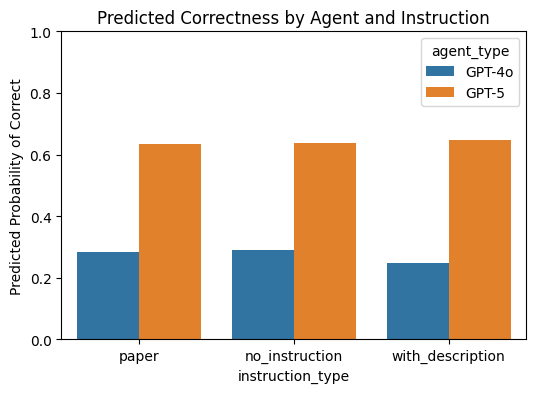

In [6]:
df_pred = pd.DataFrame({
    "agent_type": ["GPT-4o", "GPT-5"] * 3,
    "instruction_type": ["paper"]*2 + ["no_instruction"]*2 + ["with_description"]*2
})


df_pred["pred_prob"] = result_bin.predict(df_pred)

print(df_pred)

plt.figure(figsize=(6,4))
sns.barplot(
    data=df_pred,
    x="instruction_type", 
    y="pred_prob", 
    hue="agent_type",
    errorbar=None
)
plt.ylabel("Predicted Probability of Correct")
plt.title("Predicted Correctness by Agent and Instruction")
plt.ylim(0,1)
plt.show()

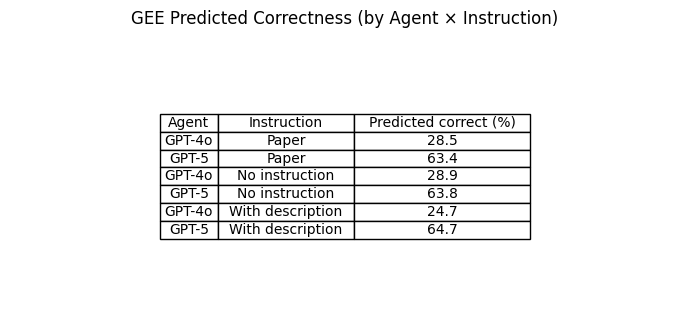

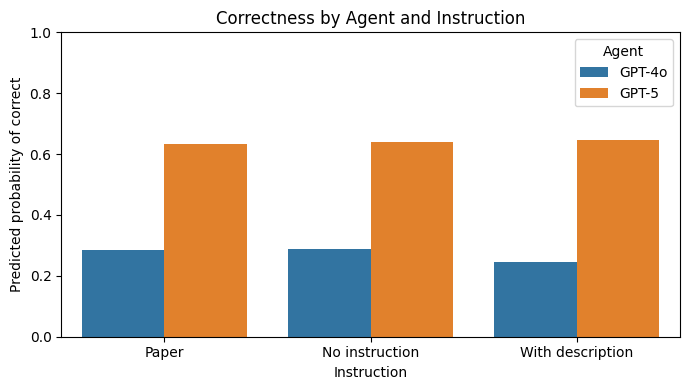

In [ ]:
agent_values = sorted(df_binary["agent_type"].unique())
instr_values = ["paper", "no_instruction", "with_description"]

df_pred = pd.DataFrame({
    "agent_type": ["GPT-4o", "GPT-5"] * 3,
    "instruction_type": ["paper"]*2 + ["no_instruction"]*2 + ["with_description"]*2
})


df_pred["agent_type"] = df_pred["agent_type"].astype(CategoricalDtype(categories=agent_values))
df_pred["instruction_type"] = df_pred["instruction_type"].astype(CategoricalDtype(categories=instr_values))


df_pred["pred_prob"] = result_bin.predict(df_pred)
df_pred["pred_pct"] = (df_pred["pred_prob"] * 100).round(1)

instr_label_map = {
    "paper": "Paper",
    "no_instruction": "No instruction",
    "with_description": "With description"
}
agent_label_map = {a: a for a in agent_values}

df_show = df_pred.copy()
df_show["Instruction"] = df_show["instruction_type"].map(instr_label_map)
df_show["Agent"] = df_show["agent_type"].map(agent_label_map)
df_show = df_show[["Agent", "Instruction", "pred_pct"]].rename(columns={"pred_pct": "Predicted correct (%)"})


fig, ax = plt.subplots(figsize=(7, 0.65 + 0.45*len(df_show)))
ax.axis("off")

tbl = ax.table(
    cellText=df_show.values,
    colLabels=df_show.columns,
    cellLoc="center",
    loc="center"
)
tbl.auto_set_font_size(False)
tbl.set_fontsize(10)
for i, col in enumerate(df_show.columns):
    tbl.auto_set_column_width(col=i)


ax.set_title("GEE Predicted Correctness (by Agent × Instruction)", fontsize=12, pad=10)
plt.tight_layout()
plt.savefig("gee_pred_table.png", dpi=300, bbox_inches="tight")
plt.show()


df_plot = df_pred.copy()
df_plot["Instruction"] = df_plot["instruction_type"].map(instr_label_map)
df_plot["Agent"] = df_plot["agent_type"].map(agent_label_map)

plt.figure(figsize=(7, 4))
sns.barplot(
    data=df_plot,
    x="Instruction",
    y="pred_prob",
    hue="Agent",
    errorbar=None
)
plt.ylabel("Predicted probability of correct")
plt.ylim(0, 1)
plt.title("Correctness by Agent and Instruction")
plt.tight_layout()
plt.savefig("gee_pred_bars.png", dpi=300, bbox_inches="tight")
plt.show()

In [ ]:
import numpy as np
import pandas as pd
import warnings


CONT_SETS = ["holf", "holf2"]
dfc = all_evaluated_df[all_evaluated_df["test_type"].isin(CONT_SETS)].copy()

dfc["y"]  = pd.to_numeric(dfc["correct_answer"], errors="coerce")
dfc["yh"] = pd.to_numeric(dfc["agent_response"], errors="coerce")


def _eps_for_group(s):
    s = s.dropna().abs()
    if len(s) == 0:
        return 1e-9
    return max(1e-9, np.nanpercentile(s, 5) * 0.1)

eps_map = dfc.groupby("test_type")["y"].apply(_eps_for_group).to_dict()
dfc["eps"] = dfc["test_type"].map(eps_map)


dfc["lrae"] = (np.log(np.abs(dfc["yh"]).add(dfc["eps"])) - np.log(np.abs(dfc["y"]).add(dfc["eps"]))).abs()
dfc["is_valid_numeric"] = (~dfc["yh"].isna()) & (~dfc["y"].isna())


valid_lrae = dfc.loc[dfc["is_valid_numeric"], "lrae"]
if len(valid_lrae) >= 5:
    penalty = float(min(valid_lrae.quantile(0.95) * 1.1, np.log(10)))
else:
    penalty = float(np.log(10))
dfc["lrae_filled"] = dfc["lrae"].fillna(penalty)


miss_table = (
    dfc.assign(missing=~dfc["is_valid_numeric"])
       .groupby(["agent_type", "instruction_type", "test_type"], as_index=False)
       .agg(n_total=("missing","size"),
            n_missing=("missing","sum"))
)
miss_table["missing_rate"] = miss_table["n_missing"] / miss_table["n_total"]
print("\n[Missing summary for numeric questions]")
print(miss_table.sort_values(["test_type","agent_type","instruction_type"]).to_string(index=False))


cols = ["lrae_filled", "agent_type", "instruction_type", "item_id", "test_type"]
dfm = dfc.loc[:, cols].rename(columns={"lrae_filled":"error"}).copy()


dfm["agent_type"]       = dfm["agent_type"].astype("category").cat.remove_unused_categories()
dfm["instruction_type"] = dfm["instruction_type"].astype("category").cat.remove_unused_categories()
dfm["item_id"]          = dfm["item_id"].astype("string")
before = len(dfm)
dfm = dfm.dropna(subset=["error","agent_type","instruction_type","item_id"]).reset_index(drop=True)
after = len(dfm)
print(f"\n[Data cleaning] dropna: {before} -> {after}")

vc = dfm["item_id"].value_counts()
multi_ids = vc[vc > 1].index
rows_kept = dfm["item_id"].isin(multi_ids).sum()
print(f"[Data cleaning] rows with item_id occurring >=2: {rows_kept} / {len(dfm)}")
dfm = dfm[dfm["item_id"].isin(multi_ids)].reset_index(drop=True)

grp_codes, grp_uniques = pd.factorize(dfm["item_id"], sort=True)
dfm["grp_code"] = grp_codes.astype(int)


dfm["agent_type"]       = dfm["agent_type"].cat.remove_unused_categories()
dfm["instruction_type"] = dfm["instruction_type"].cat.remove_unused_categories()

print(f"[Groups] #items (groups) = {dfm['grp_code'].nunique()}, N rows = {len(dfm)}")
print("[Levels] agent_type=", list(dfm["agent_type"].cat.categories),
      " instruction_type=", list(dfm["instruction_type"].cat.categories))



import statsmodels.formula.api as smf
import statsmodels.api as sm
from statsmodels.genmod.generalized_estimating_equations import GEE
from statsmodels.genmod.families import Gaussian
from statsmodels.genmod.cov_struct import Exchangeable

formula = "error ~ C(agent_type) * C(instruction_type)"

def fit_lmm(data):
    model = smf.mixedlm(formula=formula, data=data, groups=data["grp_code"], missing="drop")
    res = model.fit(reml=True, method="lbfgs")
    return res

def fit_gee(data):
    gee = GEE.from_formula(formula=formula,
                           groups="grp_code",
                           cov_struct=Exchangeable(),
                           family=Gaussian(),
                           data=data)
    res = gee.fit()
    return res

print("\n[Fitting]")
try:
    res = fit_lmm(dfm)
    print("\n--- LMM summary (MixedLM) ---")
    print(res.summary())
    used = "LMM"
except Exception as e:
    warnings.warn(f"LMM failed with: {repr(e)}; falling back to GEE.")
    res = fit_gee(dfm)
    print("\n--- GEE summary ---")
    print(res.summary())
    used = "GEE"


try:
    import patsy
    at_levels = list(dfm["agent_type"].cat.categories)
    pt_levels = list(dfm["instruction_type"].cat.categories)
    grid = pd.DataFrame([(a,p) for a in at_levels for p in pt_levels],
                        columns=["agent_type","instruction_type"])
    grid["agent_type"]       = pd.Categorical(grid["agent_type"], categories=at_levels)
    grid["instruction_type"] = pd.Categorical(grid["instruction_type"], categories=pt_levels)

    if used == "LMM":
        y, X = patsy.dmatrices(formula, dfm, return_type="dataframe")
        Xg   = patsy.dmatrix("C(agent_type) * C(instruction_type)", grid, return_type="dataframe")
        fe   = res.fe_params.reindex(X.columns, fill_value=0.0)
        grid["pred_error"] = np.dot(Xg, fe.values)
    else:
        y, X = patsy.dmatrices(formula, dfm, return_type="dataframe")
        Xg   = patsy.dmatrix("C(agent_type) * C(instruction_type)", grid, return_type="dataframe")
        beta = res.params.reindex(X.columns, fill_value=0.0)
        grid["pred_error"] = np.dot(Xg, beta.values)

    print("\n[Estimated marginal mean error (by agent × prompt)]")
    print(grid.sort_values(["agent_type","instruction_type"]).to_string(index=False))
except Exception as e:
    warnings.warn(f"EMMeans step skipped: {repr(e)}")

C:\Users\14357\AppData\Local\Temp\ipykernel_38412\1493972112.py:39: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(["agent_type", "instruction_type", "test_type"], as_index=False)



[Missing summary for numeric questions]
agent_type instruction_type test_type  n_total  n_missing  missing_rate
    GPT-4o            paper      holf      150          2      0.013333
    GPT-4o   no_instruction      holf      150          1      0.006667
    GPT-4o with_description      holf      150          5      0.033333
     GPT-5            paper      holf      150          0      0.000000
     GPT-5   no_instruction      holf      150          1      0.006667
     GPT-5 with_description      holf      150         19      0.126667
    GPT-4o            paper     holf2      150          0      0.000000
    GPT-4o   no_instruction     holf2      150          0      0.000000
    GPT-4o with_description     holf2      150          0      0.000000
     GPT-5            paper     holf2      150          0      0.000000
     GPT-5   no_instruction     holf2      150          0      0.000000
     GPT-5 with_description     holf2      150          0      0.000000

[Data cleaning] dropna

In [ ]:
from pathlib import Path
outdir = Path(".")
outdir.mkdir(parents=True, exist_ok=True)

prompt_levels = list(pd.Categorical(grid["instruction_type"]).categories) if isinstance(grid["instruction_type"].dtype, pd.CategoricalDtype) else sorted(grid["instruction_type"].unique())
agent_levels  = list(pd.Categorical(grid["agent_type"]).categories)       if isinstance(grid["agent_type"].dtype, pd.CategoricalDtype)       else sorted(grid["agent_type"].unique())

x = np.arange(len(prompt_levels))
width = 0.35

fig, ax = plt.subplots(figsize=(8,6))
for i, agent in enumerate(agent_levels):
    vals = [float(grid.loc[(grid["agent_type"]==agent) & (grid["instruction_type"]==p), "pred_error"].iloc[0]) for p in prompt_levels]
    ax.bar(x + (i - (len(agent_levels)-1)/2)*width, vals, width, label=agent)

ax.set_xticks(x)
ax.set_xticklabels(prompt_levels, rotation=0)
ax.set_ylabel("Predicted log-ratio error (LRAE)")
ax.set_xlabel("Prompt type")
ax.set_title("Estimated marginal mean error by LLM × Prompt")
ax.legend(title="Agent")
fig.tight_layout()
fig.savefig(outdir/"main_error_bar.png", dpi=300)
plt.close(fig)

miss_overall = (miss_table
                .groupby(["agent_type","instruction_type"], as_index=False)
                .agg(n_total=("n_total","sum"), n_missing=("n_missing","sum")))
miss_overall["missing_rate"] = miss_overall["n_missing"] / miss_overall["n_total"]

fig, ax = plt.subplots(figsize=(8,6))
for i, agent in enumerate(agent_levels):
    vals = [float(miss_overall.loc[(miss_overall["agent_type"]==agent) & (miss_overall["instruction_type"]==p), "missing_rate"].iloc[0])
            if not miss_overall.loc[(miss_overall["agent_type"]==agent) & (miss_overall["instruction_type"]==p)].empty else 0.0
            for p in prompt_levels]
    ax.bar(x + (i - (len(agent_levels)-1)/2)*width, vals, width, label=agent)

ax.set_xticks(x)
ax.set_xticklabels(prompt_levels, rotation=0)
ax.set_ylabel("Missing rate")
ax.set_xlabel("Prompt type")
ax.set_title("Missing rate by LLM × Prompt (overall across datasets)")
ax.legend(title="Agent")
fig.tight_layout()
fig.savefig(outdir/"main_missing_bar.png", dpi=300)
plt.close(fig)


coef_df = pd.DataFrame({"coef": res.params})
if hasattr(res, "bse"):
    coef_df["std_err"] = res.bse
if hasattr(res, "conf_int"):
    try:
        ci = res.conf_int()
        ci = pd.DataFrame(ci)
        ci.columns = ["ci_low","ci_high"]
        coef_df = coef_df.join(ci)
    except Exception:
        pass

coef_df.to_csv(outdir/"main_coef_table.csv", index=True)
with open(outdir/"main_model_summary.txt", "w", encoding="utf-8") as f:
    f.write(str(res.summary()))


appendix_overall = pd.merge(grid, 
                            miss_overall[["agent_type","instruction_type","missing_rate"]],
                            on=["agent_type","instruction_type"], how="left")
appendix_overall.to_csv(outdir/"appendix_overall_pred_error_and_missing.csv", index=False)


fig, ax = plt.subplots(figsize=(10, 4.5))
ax.axis('off')
tbl = ax.table(cellText=appendix_overall.round(3).values,
               colLabels=appendix_overall.columns,
               loc='center')
tbl.auto_set_font_size(False)
tbl.set_fontsize(8)
tbl.auto_set_column_width(col=list(range(len(appendix_overall.columns))))
fig.tight_layout()
fig.savefig(outdir/"appendix_overall_pred_error_and_missing.png", dpi=300, bbox_inches="tight")
plt.close(fig)


obs_means = (dfm.groupby(["test_type","agent_type","instruction_type"], as_index=False)["error"]
                .mean().rename(columns={"error":"mean_lrae"}))

miss_by_test = miss_table.copy()
miss_by_test = miss_by_test[["test_type","agent_type","instruction_type","n_total","n_missing","missing_rate"]]
appendix_by_test = pd.merge(obs_means, miss_by_test, on=["test_type","agent_type","instruction_type"], how="left")
appendix_by_test.to_csv(outdir/"appendix_by_test_observed_means_and_missing.csv", index=False)


fig, ax = plt.subplots(figsize=(12, 6))
ax.axis('off')
tbl = ax.table(cellText=appendix_by_test.round(3).values,
               colLabels=appendix_by_test.columns,
               loc='center')
tbl.auto_set_font_size(False)
tbl.set_fontsize(8)
tbl.auto_set_column_width(col=list(range(len(appendix_by_test.columns))))
fig.tight_layout()
fig.savefig(outdir/"appendix_by_test_observed_means_and_missing.png", dpi=300, bbox_inches="tight")
plt.close(fig)

print("Saved files:",
      (outdir/"main_error_bar.png").resolve(),
      (outdir/"main_missing_bar.png").resolve(),
      (outdir/"main_coef_table.csv").resolve(),
      (outdir/"main_model_summary.txt").resolve(),
      (outdir/"appendix_overall_pred_error_and_missing.csv").resolve(),
      (outdir/"appendix_overall_pred_error_and_missing.png").resolve(),
      (outdir/"appendix_by_test_observed_means_and_missing.csv").resolve(),
      (outdir/"appendix_by_test_observed_means_and_missing.png").resolve(),
)

C:\Users\14357\AppData\Local\Temp\ipykernel_38412\2173552330.py:30: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(["agent_type","instruction_type"], as_index=False)
C:\Users\14357\AppData\Local\Temp\ipykernel_38412\2173552330.py:90: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  obs_means = (dfm.groupby(["test_type","agent_type","instruction_type"], as_index=False)["error"]


Saved files: D:\osu\osu\OSU\OSU\2025summer\projects\osfstorage-archive_OSF_ver\analysis\main_error_bar.png D:\osu\osu\OSU\OSU\2025summer\projects\osfstorage-archive_OSF_ver\analysis\main_missing_bar.png D:\osu\osu\OSU\OSU\2025summer\projects\osfstorage-archive_OSF_ver\analysis\main_coef_table.csv D:\osu\osu\OSU\OSU\2025summer\projects\osfstorage-archive_OSF_ver\analysis\main_model_summary.txt D:\osu\osu\OSU\OSU\2025summer\projects\osfstorage-archive_OSF_ver\analysis\appendix_overall_pred_error_and_missing.csv D:\osu\osu\OSU\OSU\2025summer\projects\osfstorage-archive_OSF_ver\analysis\appendix_overall_pred_error_and_missing.png D:\osu\osu\OSU\OSU\2025summer\projects\osfstorage-archive_OSF_ver\analysis\appendix_by_test_observed_means_and_missing.csv D:\osu\osu\OSU\OSU\2025summer\projects\osfstorage-archive_OSF_ver\analysis\appendix_by_test_observed_means_and_missing.png


In [ ]:

BASELINE_NAME = "CHART-6"

def pretty_label(term):
    if term == "Intercept":
        return f"Intercept (ref: GPT-4o, {BASELINE_NAME})"
    if term.startswith("C(agent_type)[T.") and ":" not in term:
        lvl = term.split("[T.")[-1].rstrip("]")
        return f"GPT-5 vs GPT-4o" if lvl == "GPT-5" else f"LLM: {lvl} vs GPT-4o"
    if term.startswith("C(instruction_type)[T.") and ":" not in term:
        lvl = term.split("[T.")[-1].rstrip("]")
        if lvl == "no_instruction":
            return f"Question Only vs {BASELINE_NAME}"
        elif lvl == "with_description":
            return f"GPT-5 Description vs {BASELINE_NAME}"
        else:
            return f"Prompt: {lvl} vs {BASELINE_NAME}"

    if ":" in term:
        a, b = term.split(":")
        def _lvl(s, prefix):
            return s.split("[T.")[-1].rstrip("]") if s.startswith(prefix) else s
        if "C(agent_type)" in a and "C(instruction_type)" in b:
            llm = _lvl(a, "C(agent_type)")
            prm = _lvl(b, "C(instruction_type)")
        elif "C(instruction_type)" in a and "C(agent_type)" in b:
            prm = _lvl(a, "C(instruction_type)")
            llm = _lvl(b, "C(agent_type)")
        else:
            return term

        if llm == "GPT-5" and prm == "no_instruction":
            return "Interaction: GPT-5 + Question Only"
        if llm == "GPT-5" and prm == "with_description":
            return "Interaction: GPT-5 + GPT-5 Description"
        return f"Interaction: {llm} × {prm}"
    return term


def normalize_term(t: str) -> str:
    t = re.sub(r"C\(([^)]+)\)", r"\1", t)
    return t


label_map = {
    "agent_type[T.GPT-5]": "GPT-5 vs GPT-4o",
    "instruction_type[T.no_instruction]": "Question Only vs CHART-6",
    "instruction_type[T.with_description]": "GPT-5 Description vs CHART-6",
    "agent_type[T.GPT-5]:instruction_type[T.no_instruction]": "Interaction: GPT-5 + Question Only",
    "agent_type[T.GPT-5]:instruction_type[T.with_description]": "Interaction: GPT-5 + GPT-5 Description"
}


coef_df["label"] = coef_df["term"].apply(
    lambda t: label_map.get(normalize_term(t), pretty_label(t))
)


order = [
    "GPT-5 vs GPT-4o",
    "Question Only vs CHART-6",
    "GPT-5 Description vs CHART-6",
    "Interaction: GPT-5 + Question Only",
    "Interaction: GPT-5 + GPT-5 Description"
]


cats = (["Intercept (ref: GPT-4o, CHART-6)"] if (coef_df["label"] == f"Intercept (ref: GPT-4o, {BASELINE_NAME})").any() else []) + order
coef_df["label"] = pd.Categorical(coef_df["label"], categories=cats, ordered=True)
coef_df = coef_df.sort_values("label")


def tidy_from_result(res):
    params = pd.Series(res.params, name="coef")
    df = params.to_frame()
    df["std_err"] = res.bse if hasattr(res, "bse") else np.nan
    # CI
    if hasattr(res, "conf_int"):
        try:
            ci = pd.DataFrame(res.conf_int())
            if ci.shape[1] == 2:
                ci.columns = ["ci_low","ci_high"]
                df = df.join(ci)
        except Exception:
            pass
    if "ci_low" not in df.columns or df["ci_low"].isna().all():
        # Wald 95% as fallback
        if "std_err" in df.columns and not df["std_err"].isna().all():
            z = 1.96
            df["ci_low"] = df["coef"] - z*df["std_err"]
            df["ci_high"] = df["coef"] + z*df["std_err"]
        else:
            df["ci_low"] = np.nan
            df["ci_high"] = np.nan
    df["p_value"] = res.pvalues if hasattr(res, "pvalues") else np.nan
    df = df.reset_index().rename(columns={"index":"term"})
    return df

def pretty_label(term):
    if term == "Intercept":
        return "Intercept (ref: GPT-4o, paper)"
    if term.startswith("C(agent_type)[T.") and ":" not in term:
        lvl = term.split("[T.")[-1].rstrip("]")
        return f"LLM: {lvl} vs GPT-4o"
    if term.startswith("C(instruction_type)[T.") and ":" not in term:
        lvl = term.split("[T.")[-1].rstrip("]")
        return f"Prompt: {lvl} vs paper"
    if ":" in term:
        a, b = term.split(":")
        def _lvl(s, prefix):
            return s.split("[T.")[-1].rstrip("]") if s.startswith(prefix) else s
        if "C(agent_type)" in a and "C(instruction_type)" in b:
            llm = _lvl(a, "C(agent_type)")
            prm = _lvl(b, "C(instruction_type)")
        elif "C(instruction_type)" in a and "C(agent_type)" in b:
            prm = _lvl(a, "C(instruction_type)")
            llm = _lvl(b, "C(agent_type)")
        else:
            return term
        return f"Interaction: {llm} × {prm}"
    return term

coef_df = tidy_from_result(res)
coef_df = coef_df[~coef_df["term"].isin(["Group Var","Scale","Residual","Intercept RE","Intercept RE Std"])].copy()
coef_df["label"] = coef_df["term"].apply(pretty_label)
coef_df["rank"] = coef_df["term"].apply(lambda t: (0,t) if t=="Intercept" else ((1,t) if ":" not in t else (2,t)))
coef_df = coef_df.sort_values("rank")

coef_df[["term","label","coef","std_err","ci_low","ci_high","p_value"]].to_csv("fixed_effects_coefficients.csv", index=False)

# Forest plot
fig, ax = plt.subplots(figsize=(8, max(2.5, 0.5*len(coef_df))))
y = np.arange(len(coef_df))[::-1]
ax.errorbar(
    coef_df["coef"].values,
    y,
    xerr=[coef_df["coef"].values - coef_df["ci_low"].values,
          coef_df["ci_high"].values - coef_df["coef"].values],
    fmt="o",
    capsize=3
)
ax.axvline(0.0, linestyle="--")
ax.set_yticks(y)
ax.set_yticklabels(coef_df["label"].tolist())
ax.set_xlabel("Coefficient (effect on log-ratio error)")
ax.set_title("Fixed effects with 95% CI")
plt.tight_layout()
plt.savefig("coef_forest.png", dpi=300, bbox_inches="tight")
plt.close()

ranked = coef_df.assign(abs_coef=lambda d: d["coef"].abs()) \
                .sort_values("abs_coef", ascending=False) \
                [["label","coef","ci_low","ci_high","p_value"]]
ranked.to_csv("coef_forest_summary.csv", index=False)

KeyError: 'term'

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf


CONT_SETS = ["holf", "holf2"]
dfc = all_evaluated_df[all_evaluated_df["test_type"].isin(CONT_SETS)].copy()

dfc["y"]  = pd.to_numeric(dfc["correct_answer"], errors="coerce")
dfc["yh"] = pd.to_numeric(dfc["agent_response"], errors="coerce")

def _eps_for_group(s):
    s = s.dropna().abs()
    if len(s) == 0:
        return 1e-9
    return max(1e-9, np.nanpercentile(s, 5) * 0.1)

eps_map = dfc.groupby("test_type")["y"].apply(_eps_for_group).to_dict()
dfc["eps"] = dfc["test_type"].map(eps_map)

# log-ratio absolute error
dfc["lrae"] = (np.log(np.abs(dfc["yh"]).add(dfc["eps"])) - 
               np.log(np.abs(dfc["y"]).add(dfc["eps"]))).abs()

valid_lrae = dfc["lrae"].dropna()
penalty = float(min(valid_lrae.quantile(0.95) * 1.1 if len(valid_lrae) >= 5 else np.log(10), np.log(10)))
dfc["error"] = dfc["lrae"].fillna(penalty)

cols = ["error", "agent_type", "instruction_type", "item_id"]
dfm = dfc.loc[:, cols].copy()

dfm["agent_type"]       = dfm["agent_type"].astype("category").cat.remove_unused_categories()
dfm["instruction_type"] = dfm["instruction_type"].astype("category").cat.remove_unused_categories()
dfm["item_id"]          = dfm["item_id"].astype("string")
dfm = dfm.dropna(subset=["error","agent_type","instruction_type","item_id"]).reset_index(drop=True)

vc = dfm["item_id"].value_counts()
multi_ids = vc[vc > 1].index
dfm = dfm[dfm["item_id"].isin(multi_ids)].reset_index(drop=True)

grp_codes, _ = pd.factorize(dfm["item_id"], sort=True)
dfm["grp_code"] = grp_codes.astype(int)
dfm["agent_type"]       = dfm["agent_type"].cat.remove_unused_categories()
dfm["instruction_type"] = dfm["instruction_type"].cat.remove_unused_categories()


formula = "error ~ C(agent_type) * C(instruction_type)"
model = smf.mixedlm(formula=formula, data=dfm, groups=dfm["grp_code"], missing="drop")
res = model.fit(reml=True, method="lbfgs")


BASELINE_NAME = "CHART-6"

coef_df = pd.DataFrame({"coef": res.fe_params})
if hasattr(res, "bse"):
    coef_df["std_err"] = res.bse
try:
    ci = res.conf_int()
    ci = pd.DataFrame(ci, columns=["ci_low","ci_high"])
    coef_df = coef_df.join(ci)
except Exception:
    if "std_err" in coef_df.columns:
        z = 1.96
        coef_df["ci_low"]  = coef_df["coef"] - z*coef_df["std_err"]
        coef_df["ci_high"] = coef_df["coef"] + z*coef_df["std_err"]
    else:
        coef_df["ci_low"] = np.nan
        coef_df["ci_high"] = np.nan

coef_df = coef_df.reset_index().rename(columns={"index":"term"})

import re
def normalize_term(t: str) -> str:
    return re.sub(r"C\(([^)]+)\)", r"\1", str(t))

label_map = {
    "agent_type[T.GPT-5]": "GPT-5 vs GPT-4o",
    "instruction_type[T.no_instruction]": "Question Only vs CHART-6",
    "instruction_type[T.with_description]": "GPT-5 Description vs CHART-6",
    "agent_type[T.GPT-5]:instruction_type[T.no_instruction]": "Interaction: GPT-5 + Question Only",
    "agent_type[T.GPT-5]:instruction_type[T.with_description]": "Interaction: GPT-5 + GPT-5 Description",
}

def pretty_label(term: str) -> str:
    if term == "Intercept":
        return f"Intercept (ref: GPT-4o, {BASELINE_NAME})"
    nt = normalize_term(term)
    if nt in label_map:
        return label_map[nt]
    return nt

coef_df["label"] = coef_df["term"].apply(pretty_label)


order = [
    "GPT-5 vs GPT-4o",
    "Question Only vs CHART-6",
    "GPT-5 Description vs CHART-6",
    "Interaction: GPT-5 + Question Only",
    "Interaction: GPT-5 + GPT-5 Description",
]
show_intercept = False
cats = (["Intercept (ref: GPT-4o, CHART-6)"] if show_intercept else []) + order

coef_df = coef_df[coef_df["label"].isin(cats)].copy()
coef_df["label"] = pd.Categorical(coef_df["label"], categories=cats, ordered=True)
coef_df = coef_df.sort_values("label")


coef_df[["term","label","coef","std_err","ci_low","ci_high"]].to_csv("fixed_effects_coefficients.csv", index=False)

fig, ax = plt.subplots(figsize=(7.5, max(2.5, 0.55*len(coef_df))))
y = np.arange(len(coef_df))[::-1]
ax.errorbar(
    coef_df["coef"].values, y,
    xerr=[coef_df["coef"].values - coef_df["ci_low"].values,
          coef_df["ci_high"].values - coef_df["coef"].values],
    fmt="o", capsize=3
)
ax.axvline(0.0, linestyle="--", color="grey", linewidth=1)
ax.set_yticks(y)
ax.set_yticklabels(coef_df["label"].tolist())
ax.set_xlabel("Coefficient (effect on log-ratio error)")
ax.set_title("Fixed effects (MixedLM) with 95% CI")
plt.tight_layout()
plt.savefig("coef_forest.png", dpi=300, bbox_inches="tight")
plt.close()

In [14]:
coef_df[["term","coef","ci_low","ci_high"]].head()

term      coef  ci_low  \
1                             C(agent_type)[T.GPT-5] -0.243665     NaN   
2              C(instruction_type)[T.no_instruction]  0.017655     NaN   
3            C(instruction_type)[T.with_description] -0.009263     NaN   
4  C(agent_type)[T.GPT-5]:C(instruction_type)[T.n... -0.002972     NaN   
5  C(agent_type)[T.GPT-5]:C(instruction_type)[T.w...  0.219173     NaN   

   ci_high  
1      NaN  
2      NaN  
3      NaN  
4      NaN  
5      NaN

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf
import re


CONT_SETS = ["holf", "holf2"]
dfc = all_evaluated_df[all_evaluated_df["test_type"].isin(CONT_SETS)].copy()
dfc["y"]  = pd.to_numeric(dfc["correct_answer"], errors="coerce")
dfc["yh"] = pd.to_numeric(dfc["agent_response"], errors="coerce")


def _eps_for_group(s):
    s = s.dropna().abs()
    if len(s) == 0:
        return 1e-9
    return max(1e-9, np.nanpercentile(s, 5) * 0.1)

eps_map = dfc.groupby("test_type")["y"].apply(_eps_for_group).to_dict()
dfc["eps"] = dfc["test_type"].map(eps_map)


dfc["lrae"] = (np.log(np.abs(dfc["yh"]).add(dfc["eps"])) - 
               np.log(np.abs(dfc["y"]).add(dfc["eps"]))).abs()

max_lrae_by_ds = dfc.groupby("test_type")["lrae"].transform(lambda s: np.nanmax(s.values))
dfc["error"] = dfc["lrae"].where(dfc["lrae"].notna(), max_lrae_by_ds)

global_max = np.nanmax(dfc["lrae"].values)
fallback = global_max if np.isfinite(global_max) else np.log(10)
dfc["error"] = dfc["error"].fillna(fallback)

cols = ["error", "agent_type", "instruction_type", "item_id"]
dfm = dfc.loc[:, cols].copy()

dfm["agent_type"]       = dfm["agent_type"].astype("category").cat.remove_unused_categories()
dfm["instruction_type"] = dfm["instruction_type"].astype("category").cat.remove_unused_categories()
dfm["item_id"]          = dfm["item_id"].astype("string")
dfm = dfm.dropna(subset=["error","agent_type","instruction_type","item_id"]).reset_index(drop=True)

vc = dfm["item_id"].value_counts()
multi_ids = vc[vc > 1].index
dfm = dfm[dfm["item_id"].isin(multi_ids)].reset_index(drop=True)


grp_codes, _ = pd.factorize(dfm["item_id"], sort=True)
dfm["grp_code"] = grp_codes.astype(int)


formula = "error ~ C(agent_type) * C(instruction_type)"
model = smf.mixedlm(formula=formula, data=dfm, groups=dfm["grp_code"], missing="drop")
res = model.fit(reml=True, method="lbfgs")


BASELINE_NAME = "CHART-6"


fe_idx = res.fe_params.index
coef_df = pd.DataFrame({"coef": res.fe_params})
coef_df["std_err"] = res.bse.reindex(fe_idx)

try:
    ci = res.conf_int()
    ci = pd.DataFrame(ci, columns=["ci_low","ci_high"]).loc[fe_idx]
    coef_df = coef_df.join(ci)
except Exception:
    z = 1.96
    coef_df["ci_low"]  = coef_df["coef"] - z*coef_df["std_err"]
    coef_df["ci_high"] = coef_df["coef"] + z*coef_df["std_err"]

coef_df = coef_df.reset_index().rename(columns={"index":"term"})


label_map = {
    "agent_type[T.GPT-5]": "GPT-5 vs GPT-4o",
    "instruction_type[T.no_instruction]": "Question Only vs CHART-6",
    "instruction_type[T.with_description]": "GPT-5 Description vs CHART-6",
    "agent_type[T.GPT-5]:instruction_type[T.no_instruction]": "Interaction: GPT-5 + Question Only",
    "agent_type[T.GPT-5]:instruction_type[T.with_description]": "Interaction: GPT-5 + GPT-5 Description",
}

def normalize_term(t: str) -> str:
    return re.sub(r"C\(([^)]+)\)", r"\1", str(t))

def pretty_label(term: str) -> str:
    if term == "Intercept":
        return f"Intercept (ref: GPT-4o, {BASELINE_NAME})"
    nt = normalize_term(term)
    return label_map.get(nt, nt)

coef_df["label"] = coef_df["term"].apply(pretty_label)


order = [
    "GPT-5 vs GPT-4o",
    "Question Only vs CHART-6",
    "GPT-5 Description vs CHART-6",
    "Interaction: GPT-5 + Question Only",
    "Interaction: GPT-5 + GPT-5 Description",
]
coef_df = coef_df[coef_df["label"].isin(order)].copy()
coef_df["label"] = pd.Categorical(coef_df["label"], categories=order, ordered=True)
coef_df = coef_df.sort_values("label")


coef_df[["term","label","coef","std_err","ci_low","ci_high"]].to_csv("fixed_effects_coefficients.csv", index=False)

fig, ax = plt.subplots(figsize=(7.5, max(2.5, 0.55*len(coef_df))))
y = np.arange(len(coef_df))[::-1]
ax.errorbar(
    coef_df["coef"].values,
    y,
    xerr=[coef_df["coef"].values - coef_df["ci_low"].values,
          coef_df["ci_high"].values - coef_df["coef"].values],
    fmt="o", capsize=3
)
ax.axvline(0.0, linestyle="--", color="grey", linewidth=1)
ax.set_yticks(y)
ax.set_yticklabels(coef_df["label"].tolist())
ax.set_xlabel("Coefficient (effect on log-ratio error)")
ax.set_title("Fixed effects (MixedLM) with 95% CI")
plt.tight_layout()
plt.savefig("coef_forest.png", dpi=300, bbox_inches="tight")
plt.close()

D:\myPythonLibs\statsmodels\regression\mixed_linear_model.py:1634: UserWarning: Random effects covariance is singular
  warnings.warn(msg)
D:\myPythonLibs\statsmodels\regression\mixed_linear_model.py:2054: UserWarning: The random effects covariance matrix is singular.
  warnings.warn(_warn_cov_sing)
D:\myPythonLibs\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
D:\myPythonLibs\statsmodels\regression\mixed_linear_model.py:2245: UserWarning: The random effects covariance matrix is singular.
  warnings.warn(_warn_cov_sing)
D:\myPythonLibs\statsmodels\regression\mixed_linear_model.py:2261: ConvergenceWarning: The Hessian matrix at the estimated parameter values is not positive definite.
  warnings.warn(msg, ConvergenceWarning)


In [ ]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf
import re


CONT_SETS = ["holf", "holf2"]
dfc = all_evaluated_df[all_evaluated_df["test_type"].isin(CONT_SETS)].copy()


dfc["y"]  = pd.to_numeric(dfc["correct_answer"], errors="coerce")
dfc["yh"] = pd.to_numeric(dfc["agent_response"], errors="coerce")


def _eps_for_group(s):
    s = s.dropna().abs()
    if len(s) == 0:
        return 1e-9
    return max(1e-9, np.nanpercentile(s, 5) * 0.1)

eps_map = dfc.groupby("test_type")["y"].apply(_eps_for_group).to_dict()
dfc["eps"] = dfc["test_type"].map(eps_map)
dfc["lrae"] = (np.log(np.abs(dfc["yh"]).add(dfc["eps"])) - 
               np.log(np.abs(dfc["y"]).add(dfc["eps"]))).abs()


max_lrae_by_ds = dfc.groupby("test_type")["lrae"].transform(lambda s: np.nanmax(s.values))
dfc["error"] = dfc["lrae"].where(dfc["lrae"].notna(), max_lrae_by_ds)


global_max = np.nanmax(dfc["lrae"].values)
fallback = global_max if np.isfinite(global_max) else np.log(10)
dfc["error"] = dfc["error"].fillna(fallback)


cols = ["error", "agent_type", "instruction_type", "item_id"]
dfm = dfc.loc[:, cols].copy()

dfm["agent_type"]       = dfm["agent_type"].astype("category").cat.remove_unused_categories()
dfm["instruction_type"] = dfm["instruction_type"].astype("category").cat.remove_unused_categories()
dfm["item_id"]          = dfm["item_id"].astype("string")
dfm = dfm.dropna(subset=["error","agent_type","instruction_type","item_id"]).reset_index(drop=True)


vc = dfm["item_id"].value_counts()
multi_ids = vc[vc > 1].index
dfm = dfm[dfm["item_id"].isin(multi_ids)].reset_index(drop=True)


grp_codes, _ = pd.factorize(dfm["item_id"], sort=True)
dfm["grp_code"] = grp_codes.astype(int)


formula = "error ~ C(agent_type) * C(instruction_type)"
model = smf.mixedlm(formula=formula, data=dfm, groups=dfm["grp_code"], missing="drop")
res = model.fit(reml=True, method="lbfgs")

BASELINE_NAME = "CHART-6"

fe_idx  = res.fe_params.index
coef_df = pd.DataFrame({"term": fe_idx, "coef": res.fe_params.values})


try:
    se = pd.Series(res.bse_fe, index=fe_idx)
except Exception:
    cov = res.cov_params().loc[fe_idx, fe_idx]
    se  = pd.Series(np.sqrt(np.diag(cov)), index=fe_idx)

coef_df["std_err"] = se.values


z = 1.96
coef_df["ci_low"]  = coef_df["coef"] - z * coef_df["std_err"]
coef_df["ci_high"] = coef_df["coef"] + z * coef_df["std_err"]


import re
def normalize_term(t: str) -> str:
    return re.sub(r"C\(([^)]+)\)", r"\1", str(t))

label_map = {
    "agent_type[T.GPT-5]": "GPT-5 vs GPT-4o",
    "instruction_type[T.no_instruction]": "Question Only vs CHART-6",
    "instruction_type[T.with_description]": "GPT-5 Description vs CHART-6",
    "agent_type[T.GPT-5]:instruction_type[T.no_instruction]": "Interaction: GPT-5 + Question Only",
    "agent_type[T.GPT-5]:instruction_type[T.with_description]": "Interaction: GPT-5 + GPT-5 Description",
}

def pretty_label(term: str) -> str:
    if term == "Intercept":
        return f"Intercept (ref: GPT-4o, {BASELINE_NAME})"
    nt = normalize_term(term)
    return label_map.get(nt, nt)

coef_df["label"] = coef_df["term"].apply(pretty_label)


order = [
    "GPT-5 vs GPT-4o",
    "Question Only vs CHART-6",
    "GPT-5 Description vs CHART-6",
    "Interaction: GPT-5 + Question Only",
    "Interaction: GPT-5 + GPT-5 Description",
]
coef_df = coef_df[coef_df["label"].isin(order)].copy()
coef_df["label"] = pd.Categorical(coef_df["label"], categories=order, ordered=True)
coef_df = coef_df.sort_values("label").reset_index(drop=True)


coef_df = coef_df.replace([np.inf, -np.inf], np.nan).dropna(subset=["coef","ci_low","ci_high"])


coef_df[["term","label","coef","std_err","ci_low","ci_high"]].to_csv("fixed_effects_coefficients.csv", index=False)

fig, ax = plt.subplots(figsize=(7.5, max(2.5, 0.55*len(coef_df))))
y = np.arange(len(coef_df))[::-1]
xerr = np.vstack([
    coef_df["coef"].values - coef_df["ci_low"].values,
    coef_df["ci_high"].values - coef_df["coef"].values
])
ax.errorbar(coef_df["coef"].values, y, xerr=xerr, fmt="o", capsize=3)
ax.axvline(0.0, linestyle="--", color="grey", linewidth=1)
ax.set_yticks(y)
ax.set_yticklabels(coef_df["label"].tolist())
ax.invert_yaxis() 
ax.set_xlabel("Coefficient (effect on log-ratio error)")
ax.set_title("MixedLM fixed effects (95% CI)")
plt.tight_layout()
plt.savefig("coef_forest.png", dpi=300, bbox_inches="tight")
plt.close()

D:\myPythonLibs\statsmodels\regression\mixed_linear_model.py:1634: UserWarning: Random effects covariance is singular
  warnings.warn(msg)
D:\myPythonLibs\statsmodels\regression\mixed_linear_model.py:2054: UserWarning: The random effects covariance matrix is singular.
  warnings.warn(_warn_cov_sing)
D:\myPythonLibs\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
D:\myPythonLibs\statsmodels\regression\mixed_linear_model.py:2245: UserWarning: The random effects covariance matrix is singular.
  warnings.warn(_warn_cov_sing)
D:\myPythonLibs\statsmodels\regression\mixed_linear_model.py:2261: ConvergenceWarning: The Hessian matrix at the estimated parameter values is not positive definite.
  warnings.warn(msg, ConvergenceWarning)
